In [1]:
import seaborn as sns
from nufeb_tools import utils,plot,spatial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm,ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
import matplotlib.image as mpimg
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed, dump,load

In [2]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [3]:
DIR = Path(r'E:\fitness-prediction\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]

In [4]:
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return

# Gather datasets

In [5]:
if Path(r'E:\fitness-prediction\saved-metrics.pkl').is_file():
    data = pd.read_pickle(r'E:\fitness-prediction\saved-metrics.pkl')
else:
    with ProgressParallel(n_jobs=-1) as parallel:
        temp = parallel(delayed(collect_data)(folder) for folder in sorted(folders))
    data = pd.concat(temp)
    data.to_pickle(r'E:\fitness-prediction\saved-metrics.pkl')


predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 


In [6]:
cmaps = ["light:#03012d","light:#d99e09"]
cmaps2 = ["#03012d","#d99e09"]


In [7]:
metric2 = data[data.type==2].fillna(0)

metric_list = list(metric2.columns.drop('total biomass'))

# Plot all possible metrics vs biomass

In [8]:
data.columns

Index(['mother_cell', 'type', 'Voronoi Area', 'IPTG', 'Time',
       'Distance from center', 'total biomass', 'Nearest 1', 'Nearest 2',
       'Nearest Neighbor', 'IC1', 'IC2', 'IC', 'Relative Neighbor Dist 1',
       'Relative Neighbor Dist 2', 'Relative Neighbor Dist', 'Z1', 'Z2',
       'Z1_2', 'Z2_1', 'LogNearest 1', 'LogNearest 2', 'LogNearest', 'Inv1',
       'Inv2', 'Log Inv1', 'Log Inv2', 'Colony Area', 'initial biomass'],
      dtype='object')

In [9]:
data

,mother_cell,type,Voronoi Area,IPTG,Time,Distance from center,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,...,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,initial biomass
0,33,2,1.978817e-10,0.36692,97.222222,0.000042,18725.174159,1.068169e-05,0.000006,6.013393e-06,...,125.942342,-11.446980,-12.021521,-12.021521,9.361819e+04,166295.456827,22.893960,24.043043,15232.0,178.418964
1,32,2,1.943819e-10,0.36692,97.222222,0.000047,13613.387479,2.400483e-05,0.000004,4.053653e-06,...,84.898239,-10.637255,-12.415892,-12.415892,4.165827e+04,246691.090842,21.274511,24.831784,11924.0,309.662175
2,20,2,4.030559e-10,0.36692,97.222222,0.000046,7314.070579,2.989025e-05,0.000005,4.605432e-06,...,96.454498,-10.417978,-12.288274,-12.288274,3.345573e+04,217134.916354,20.835957,24.576548,6598.0,164.700681
3,26,2,7.323750e-10,0.36692,97.222222,0.000035,12999.941624,1.687371e-05,0.000009,9.452322e-06,...,197.966032,-10.989754,-11.569250,-11.569250,5.926379e+04,105794.105481,21.979507,23.138500,11925.0,131.594619
4,14,2,9.573191e-10,0.36692,97.222222,0.000046,21866.197226,1.254053e-05,0.000006,6.013393e-06,...,125.942342,-11.286545,-12.021521,-12.021521,7.974144e+04,166295.456827,22.573089,24.043043,15693.0,213.345049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3,1,2.044298e-09,0.02123,97.222222,0.000050,360743.295668,3.564515e-05,0.000006,5.577490e-06,...,174.689003,-10.241898,-12.096772,-12.096772,2.805431e+04,179292.103583,20.483795,24.193543,84957.0,854.539005
91,4,1,6.977255e-09,0.02123,97.222222,0.000013,535526.268738,1.774832e-05,0.000003,3.361547e-06,...,105.284866,-10.939220,-12.603109,-12.603109,5.634336e+04,297482.058654,21.878439,25.206218,118240.0,1266.849913
92,9,1,3.902051e-09,0.02123,97.222222,0.000038,332272.304106,8.139410e-07,0.000004,8.139410e-07,...,117.909816,-14.021378,-12.489859,-14.021378,1.228590e+06,265629.782806,28.042756,24.979718,72333.0,590.614837
93,5,1,0.000000e+00,0.02123,97.222222,0.000048,577973.344035,1.815485e-05,0.000005,5.195306e-06,...,162.718834,-10.916573,-12.167755,-12.167755,5.508171e+04,192481.459635,21.833146,24.335510,119251.0,1414.508417


In [10]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.1, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

In [11]:
data2 = data[data.type==1]
X = data2[predictors]
y = data2['total biomass']
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, y, train_size = 0.7, random_state = 42)
""" 



#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et1 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
model_et1.fit(train_X1, train_y1) 

pred_train_et1= model_et1.predict(train_X1)
pred_test_et1 = model_et1.predict(test_X1)

score = model_et1.score(train_X1, train_y1)
print("Score: ", score)
cv_scores = cross_val_score(model_et1, train_X1,train_y1,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y1,pred_train_et1)
axes[1].scatter(test_y1,pred_test_et1)
#Plot the diagonal line
d_line= np.arange(train_y1.min(), train_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y1.min(), test_y1.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result1 = permutation_importance(model_et1, train_X1, train_y1, random_state=0)
feats1 = pd.DataFrame([result1.importances_mean,result1.importances_std,X.columns]).T
print(feats1.sort_values(by=0,ascending=False)) """

' \n\n\n\n#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)\nmodel_et1 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)\nmodel_et1.fit(train_X1, train_y1) \n\npred_train_et1= model_et1.predict(train_X1)\npred_test_et1 = model_et1.predict(test_X1)\n\nscore = model_et1.score(train_X1, train_y1)\nprint("Score: ", score)\ncv_scores = cross_val_score(model_et1, train_X1,train_y1,cv=3)\nprint("Mean cross-validataion score: %.2f" % cv_scores.mean())\nf, axes = plt.subplots(ncols=2)\naxes[0].scatter(train_y1,pred_train_et1)\naxes[1].scatter(test_y1,pred_test_et1)\n#Plot the diagonal line\nd_line= np.arange(train_y1.min(), train_y1.max())\naxes[0].plot(d_line, d_line, color=\'red\', linestyle=\'--\')\nd_line= np.arange(test_y1.min(), test_y1.max())\naxes[1].plot(d_line, d_line, color=\'red\', linestyle=\'--\')\naxes[0].set_title(\'Train fit\')\naxes[1].set_title(\'Test fit\')\nplt.show()\n#feats = pd.DataF

In [12]:
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X2, test_X2, train_y2, test_y2 = train_test_split(X, y, train_size = 0.7, random_state = 42)
""" 

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et2 = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)
model_et2.fit(train_X2, train_y2) 

pred_train_et2= model_et2.predict(train_X2)
pred_test_et2 = model_et2.predict(test_X2)

score2 = model_et2.score(train_X2, train_y2)
print("Score: ", score)
cv_scores2 = cross_val_score(model_et2, train_X2,train_y2,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y2,pred_train_et2)
axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(train_y2.min(), train_y2.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result2 = permutation_importance(model_et2, train_X2, train_y2, random_state=0)
feats2 = pd.DataFrame([result2.importances_mean,result2.importances_std,X.columns]).T
print(feats2.sort_values(by=0,ascending=False)) """

' \n\n#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)\nmodel_et2 = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)\nmodel_et2.fit(train_X2, train_y2) \n\npred_train_et2= model_et2.predict(train_X2)\npred_test_et2 = model_et2.predict(test_X2)\n\nscore2 = model_et2.score(train_X2, train_y2)\nprint("Score: ", score)\ncv_scores2 = cross_val_score(model_et2, train_X2,train_y2,cv=3)\nprint("Mean cross-validataion score: %.2f" % cv_scores.mean())\nf, axes = plt.subplots(ncols=2)\naxes[0].scatter(train_y2,pred_train_et2)\naxes[1].scatter(test_y2,pred_test_et2)\n#Plot the diagonal line\nd_line= np.arange(train_y2.min(), train_y2.max())\naxes[0].plot(d_line, d_line, color=\'red\', linestyle=\'--\')\nd_line= np.arange(test_y2.min(), test_y2.max())\naxes[1].plot(d_line, d_line, color=\'red\', linestyle=\'--\')\naxes[0].set_title(\'Train fit\')\naxes[1].set_title(\'Test fit\')\nplt.show()\n#feats = pd.DataFr

In [13]:
X = data[predictors]
y = data['total biomass']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.7, random_state = 42)

Score:  1.0
Mean cross-validataion score: 0.93


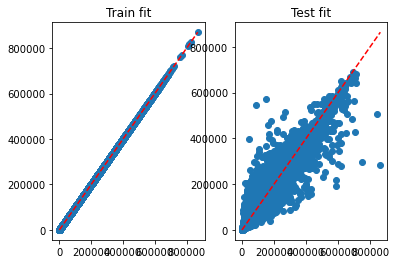

KeyboardInterrupt: 

In [14]:
if Path("../models/extra_trees.joblib").is_file():
    model_et  =load("../models/extra_trees.joblib")
else:

    model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
    model_et.fit(train_X, train_y) 
    dump(model_et, "../models/extra_trees.joblib", compress=3)
pred_train_et= model_et.predict(train_X)
pred_test_et = model_et.predict(test_X)

score = model_et.score(train_X, train_y)
print("Score: ", score)
cv_scores = cross_val_score(model_et, train_X,train_y,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y,pred_train_et)
axes[1].scatter(test_y,pred_test_et)
#Plot the diagonal line
d_line= np.arange(train_y.min(), train_y.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y.min(), test_y.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
result = permutation_importance(model_et, train_X, train_y, random_state=0)
feats= pd.DataFrame([result.importances_mean,result.importances_std,X.columns]).T
print(feats.sort_values(by=0,ascending=False))
    

In [15]:
""" predict = model_et.predict(test_X.loc[test_X.type==1])
r2=r2_score(test_y,predict)
plt.scatter(test_y,predict,label=f'Fit $R^2$={r2:.2f}')
d_line= np.arange(test_y.min(), test_y.max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.legend() """

" predict = model_et.predict(test_X.loc[test_X.type==1])\nr2=r2_score(test_y,predict)\nplt.scatter(test_y,predict,label=f'Fit $R^2$={r2:.2f}')\nd_line= np.arange(test_y.min(), test_y.max())\nplt.plot(d_line, d_line, color='red', linestyle='--')\nplt.legend() "

In [16]:
test_X

,type,Voronoi Area,IPTG,Time,Distance from center,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z1_2,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,initial biomass
78,2,8.850936e-11,0.00741,83.611111,0.000034,0.000004,0.000005,0.000004,0.000007,0.000006,...,439.783194,172.550117,-12.551444,-12.195615,-12.551444,282502.783637,197919.325366,25.102887,24.391230,258.520858
42,1,6.999181e-09,0.00478,97.222222,0.000035,0.000007,0.000004,0.000004,0.000011,0.000012,...,491.324624,63.050389,-11.895396,-12.505264,-12.505264,146590.223834,269753.524163,23.790793,25.010528,1328.804681
83,2,1.065010e-10,0.01484,97.222222,0.000049,0.000034,0.000008,0.000008,0.000018,0.000006,...,1528.522422,245.767581,-10.300526,-11.789100,-11.789100,29748.272997,131807.801546,20.601053,23.578200,139.410137
45,2,1.147482e-10,0.18961,88.611111,0.000049,0.000006,0.000002,0.000002,0.000006,0.000007,...,772.510530,49.537303,-12.064953,-13.362896,-13.362896,173677.081734,635963.000749,24.129906,26.725791,88.084771
20,2,6.072236e-11,0.00477,97.222222,0.000047,0.000004,0.000006,0.000004,0.000009,0.000008,...,350.000492,180.791018,-12.427267,-11.944775,-12.427267,249513.144621,154010.275908,24.854534,23.889549,87.207828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1,1.471244e-10,0.01004,88.888889,0.000046,0.000009,0.000008,0.000008,0.000007,0.000007,...,1081.888384,243.084793,-11.579234,-11.703684,-11.703684,106855.659624,121016.696464,23.158468,23.407368,778.738631
65,2,4.179541e-11,0.03783,97.222222,0.000041,0.000007,0.000004,0.000004,0.000010,0.000006,...,567.441746,129.738279,-11.884161,-12.469073,-12.469073,144952.503947,260165.366833,23.768323,24.938145,183.155506
74,1,3.247334e-10,0.22277,90.277778,0.000041,0.000011,0.000029,0.000011,0.000006,0.000022,...,1396.260316,276.655804,-11.437241,-10.448831,-11.437241,92710.901504,34504.017347,22.874483,20.897662,870.266325
75,1,1.673455e-10,0.00271,91.666667,0.000041,0.000018,0.000006,0.000006,0.000008,0.000007,...,1886.628280,157.312419,-10.914893,-12.091055,-12.091055,54989.223100,178270.113397,21.829785,24.182110,902.297512


In [17]:
r2_score(test_y,pred_test_et)

0.929248329895485

# Optimize n estimators


>10 0.835 (0.064)
>50 0.850 (0.059)
>100 0.853 (0.059)
>500 0.854 (0.057)
>1000 0.854 (0.057)


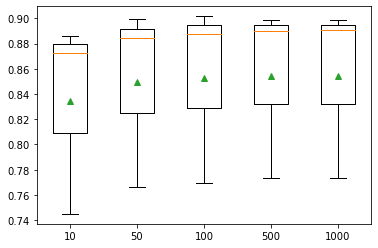

In [18]:
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = ExtraTreesRegressor(n_estimators=n, random_state=100,n_jobs=-1)
	return models

def evaluate_model(model, train_X, train_y):
	model.fit(train_X, train_y) 
	# define the evaluation procedure
	scores = cross_val_score(model, train_X,train_y,cv=3, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Optimize n features

>1 0.785 (0.003)
>2 0.846 (0.004)
>3 0.875 (0.006)
>4 0.891 (0.003)
>5 0.901 (0.004)
>6 0.909 (0.003)
>7 0.913 (0.003)
>8 0.918 (0.004)
>9 0.920 (0.003)
>10 0.921 (0.003)
>11 0.924 (0.003)
>12 0.925 (0.003)
>13 0.925 (0.003)
>14 0.926 (0.004)
>15 0.926 (0.003)
>16 0.927 (0.003)
>17 0.928 (0.003)
>18 0.928 (0.003)
>19 0.928 (0.003)
>20 0.928 (0.003)
>21 0.928 (0.004)
>22 0.928 (0.003)


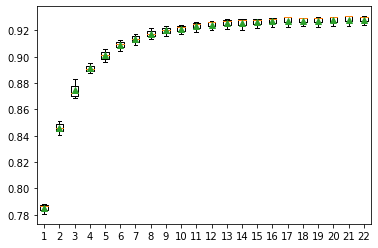

In [19]:
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1, 23):
		models[str(i)] = ExtraTreesRegressor(max_features=i)
	return models
 
# evaluate a given model using cross-validation
 
# define dataset

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, train_X, train_y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>True 0.930 (0.002)
>False 0.929 (0.003)


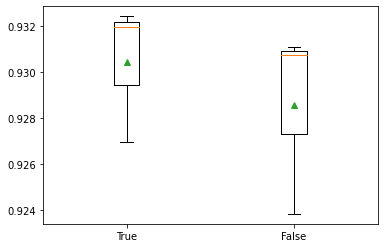

In [20]:
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in [True, False]:
		models[str(i)] = ExtraTreesRegressor(bootstrap=i)
	return models
 
# evaluate a given model using cross-validation
 
# define dataset

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, train_X, train_y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [21]:
#result = permutation_importance(model_et, train_X, train_y, random_state=0)
std = np.std([tree.feature_importances_ for tree in model_et.estimators_],
             axis=0)
perm_sorted_idx = result.importances_mean.argsort()
#feats= pd.DataFrame([result.importances_mean,result.importances_std,X.columns]).T
tree_importance_sorted_idx = np.argsort(model_et.feature_importances_)
tree_indices = np.arange(0, len(model_et.feature_importances_)) + 0.5



In [22]:
from sklearn.base import clone 
def evaluate_model(model, train_X, train_y):
	model.fit(train_X, train_y) 
	# define the evaluation procedure
	scores = cross_val_score(model, train_X,train_y,cv=3, n_jobs=-1)
	return scores
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = evaluate_model(rf_, X_train, y_train)
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = evaluate_model(rf_, X_train, y_train)
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

In [23]:
#imp = dropcol_importances(model_et, train_X, train_y)

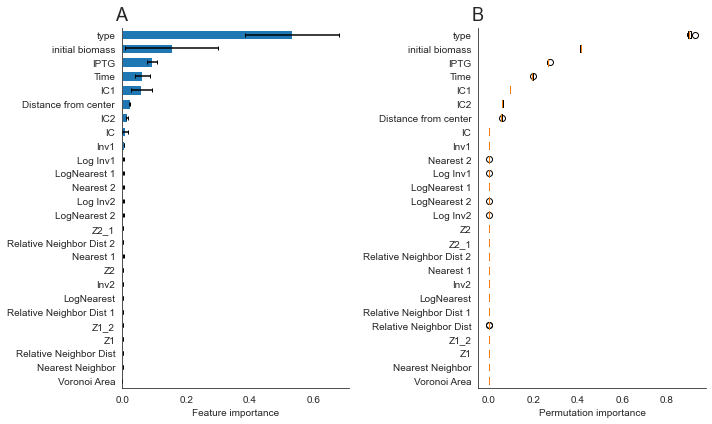

In [24]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.barh(tree_indices, model_et.feature_importances_[tree_importance_sorted_idx], xerr=std[tree_importance_sorted_idx],height=0.7,capsize=2,lw=1)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model_et.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
ax1.set_xlabel('Feature importance')
ax1.set_xlim(left=0)
ax2.set_xlabel('Permutation importance')
label_panel(ax1,'A')
label_panel(ax2,'B')
fig.tight_layout()
sns.despine()
#fig.savefig('../figures/feature_importance.png',bbox_inches='tight',dpi=600)
plt.show()

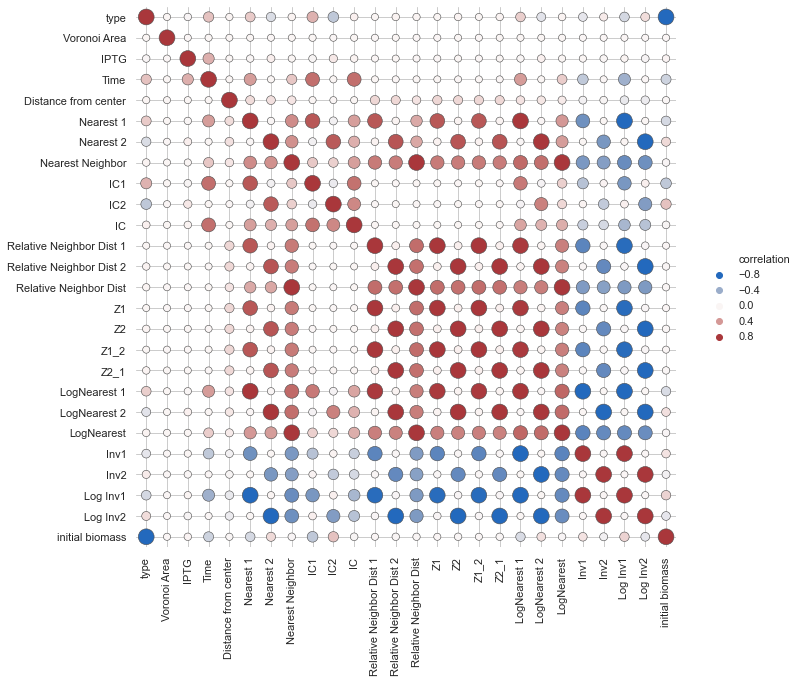

In [25]:
sns.set_theme(style="whitegrid")


# Compute a correlation matrix and convert to long-form
#corr_mat = dft.corr().stack().reset_index(name="correlation")
corr_mat = X.corr().stack().reset_index(name="correlation")
corr_mat['abs']=np.abs(corr_mat.correlation)
# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="abs",
    palette="vlag", hue_norm=(-.8, .8), edgecolor=".3",
    height=10, sizes=(50, 250), size_norm=(0, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for axes in g.axes.ravel():
    handles, labels = axes.get_legend_handles_labels()
g._legend.remove()
leg = plt.legend(handles[0:6],labels[0:6],bbox_to_anchor=(1.05, 0.55), loc=2, borderaxespad=0.,frameon=False)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
#for artist in leg.legendHandles:
    #artist.set_edgecolor(".3")


#
#g.savefig('../figures/correlation_matrix.png',bbox_inches='tight',dpi=600)
    

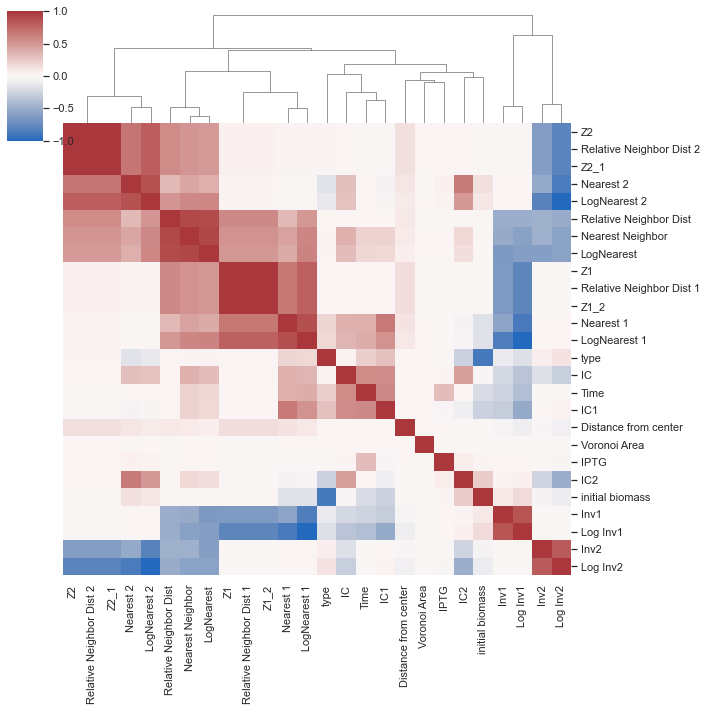

In [26]:
g=sns.clustermap(X.corr(),dendrogram_ratio=(.1, .2),cmap='vlag')
g.ax_row_dendrogram.remove()

In [42]:
model_et.decision_path(train_X)

(<34260x34259500 sparse matrix of type '<class 'numpy.int64'>'
 	with 357609637 stored elements in Compressed Sparse Row format>,
 array([       0,    68519,   137038,   205557,   274076,   342595,
          411114,   479633,   548152,   616671,   685190,   753709,
          822228,   890747,   959266,  1027785,  1096304,  1164823,
         1233342,  1301861,  1370380,  1438899,  1507418,  1575937,
         1644456,  1712975,  1781494,  1850013,  1918532,  1987051,
         2055570,  2124089,  2192608,  2261127,  2329646,  2398165,
         2466684,  2535203,  2603722,  2672241,  2740760,  2809279,
         2877798,  2946317,  3014836,  3083355,  3151874,  3220393,
         3288912,  3357431,  3425950,  3494469,  3562988,  3631507,
         3700026,  3768545,  3837064,  3905583,  3974102,  4042621,
         4111140,  4179659,  4248178,  4316697,  4385216,  4453735,
         4522254,  4590773,  4659292,  4727811,  4796330,  4864849,
         4933368,  5001887,  5070406,  5138925,  52074

In [24]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols
def colorFaderRGB(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)

    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(tuple((((1-mix[i])*c1 + mix[i]*c2)*256).astype('int')))
    return cols


In [28]:
prediction=pd.DataFrame(np.vstack([test_y,pred_test_et,test_X.type]).T,columns=['Total Biomass','Predicted Biomass','type'])
df = prediction.loc[prediction.type==1]
df2 = prediction.loc[prediction.type==2]
cya = colorFader('#01665e','#c7eae5',len(df))
ecw = colorFader('#8c510a','#f6e8c3',len(df2))

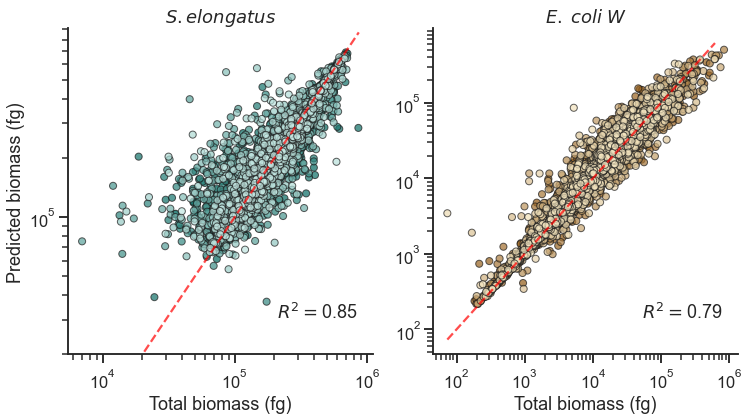

In [29]:
sns.set_theme(style="ticks")
sns.set_context('talk')
cmaps2 = ["#03012d","#d99e09"]
r2s = [r2_score(df['Total Biomass'],df['Predicted Biomass']),r2_score(df2['Total Biomass'],df2['Predicted Biomass'])]
ms = 50
f, axes = plt.subplots(ncols=2,figsize=(12,6))
#axes[0].scatter(test_y1,pred_test_et1)
#sns.scatterplot(x='Total Biomass',y='Predicted Biomass',ax=axes[0],palette=cya,data=df)
axes[0].scatter(x=df['Total Biomass'],y=df['Predicted Biomass'],s=ms,c=cya,alpha=0.7,ec='k',lw=1)
axes[1].scatter(x=df2['Total Biomass'],y=df2['Predicted Biomass'],s=ms,c=ecw,alpha=0.7,ec='k',lw=1)
#sns.scatterplot(x=test_y2,y=pred_test_et2,ax=axes[1],color="#d99e09")
#axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(test_y1.min(), test_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--',alpha=0.7)
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--',alpha=0.7)
axes[0].set_ylabel('Predicted biomass (fg)')
axes[0].set_ylim(bottom=2e4)
for r2,ax in zip(r2s,axes.ravel()):
    ax.set_xlabel('Total biomass (fg)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(0.95,0.1,f'$R^2=${r2:.2f}',transform=ax.transAxes,verticalalignment='bottom', horizontalalignment='right')
axes[0].set_title(r'$\it{S. elongatus}$')
axes[1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
sns.despine()
#f.savefig('../figures/biomass-prediction.pdf',bbox_inches='tight')

In [30]:
selected_features=feats.sort_values(by=0,ascending=False).reset_index(drop=True).iloc[:8][2]

In [31]:
selected_features=list(selected_features)

In [32]:
for element in ['type','Time','IC']:
    selected_features.remove(element)

In [33]:
#selected_features.drop([2,4,7],inplace=True)

In [34]:
selected_features

['initial biomass', 'IPTG', 'IC1', 'IC2', 'Distance from center']

In [35]:
#sns.histplot(x='initial biomass',hue='type',data=data,log_scale=True)

In [ ]:
data

,mother_cell,type,Voronoi Area,IPTG,Time,Distance from center,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,...,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,initial biomass
0,33,2,1.978817e-10,0.36692,97.222222,0.000042,18725.174159,1.068169e-05,0.000006,6.013393e-06,...,125.942342,-11.446980,-12.021521,-12.021521,9.361819e+04,166295.456827,22.893960,24.043043,15232.0,178.418964
1,32,2,1.943819e-10,0.36692,97.222222,0.000047,13613.387479,2.400483e-05,0.000004,4.053653e-06,...,84.898239,-10.637255,-12.415892,-12.415892,4.165827e+04,246691.090842,21.274511,24.831784,11924.0,309.662175
2,20,2,4.030559e-10,0.36692,97.222222,0.000046,7314.070579,2.989025e-05,0.000005,4.605432e-06,...,96.454498,-10.417978,-12.288274,-12.288274,3.345573e+04,217134.916354,20.835957,24.576548,6598.0,164.700681
3,26,2,7.323750e-10,0.36692,97.222222,0.000035,12999.941624,1.687371e-05,0.000009,9.452322e-06,...,197.966032,-10.989754,-11.569250,-11.569250,5.926379e+04,105794.105481,21.979507,23.138500,11925.0,131.594619
4,14,2,9.573191e-10,0.36692,97.222222,0.000046,21866.197226,1.254053e-05,0.000006,6.013393e-06,...,125.942342,-11.286545,-12.021521,-12.021521,7.974144e+04,166295.456827,22.573089,24.043043,15693.0,213.345049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3,1,2.044298e-09,0.02123,97.222222,0.000050,360743.295668,3.564515e-05,0.000006,5.577490e-06,...,174.689003,-10.241898,-12.096772,-12.096772,2.805431e+04,179292.103583,20.483795,24.193543,84957.0,854.539005
91,4,1,6.977255e-09,0.02123,97.222222,0.000013,535526.268738,1.774832e-05,0.000003,3.361547e-06,...,105.284866,-10.939220,-12.603109,-12.603109,5.634336e+04,297482.058654,21.878439,25.206218,118240.0,1266.849913
92,9,1,3.902051e-09,0.02123,97.222222,0.000038,332272.304106,8.139410e-07,0.000004,8.139410e-07,...,117.909816,-14.021378,-12.489859,-14.021378,1.228590e+06,265629.782806,28.042756,24.979718,72333.0,590.614837
93,5,1,0.000000e+00,0.02123,97.222222,0.000048,577973.344035,1.815485e-05,0.000005,5.195306e-06,...,162.718834,-10.916573,-12.167755,-12.167755,5.508171e+04,192481.459635,21.833146,24.335510,119251.0,1414.508417


KeyboardInterrupt: 

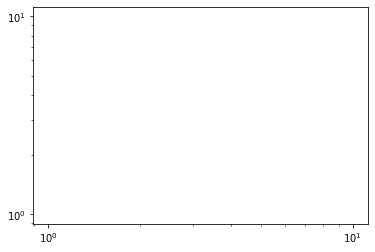

In [ ]:
sns.histplot(x='total biomass',y='initial biomass',hue='type',data=data,log_scale=True)

<AxesSubplot:xlabel='total biomass', ylabel='IPTG'>

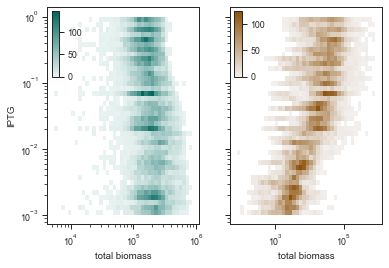

In [ ]:

f, axes = plt.subplots(ncols=2,sharey=True)
#cax = f.add_axes([.15, .55, .02, .2])
#cax2 = f.add_axes([.65, .55, .02, .2])
cya = sns.light_palette('#01665e', as_cmap=True)
ecw = sns.light_palette('#8c510a',as_cmap=True)

g=sns.histplot(x='total biomass',y='IPTG',data=data[data.type==1],log_scale=True,ax=axes[0],cbar=True,bins=40,cmap=cya,cbar_ax=cbar_inset(axes[0]))
sns.histplot(x='total biomass',y='IPTG',data=data[data.type==2],log_scale=True,ax=axes[1],cbar=True,bins=40,cmap=ecw,cbar_ax=cbar_inset(axes[1]))




#axins1.xaxis.set_ticks_position("bottom")

KeyboardInterrupt: 

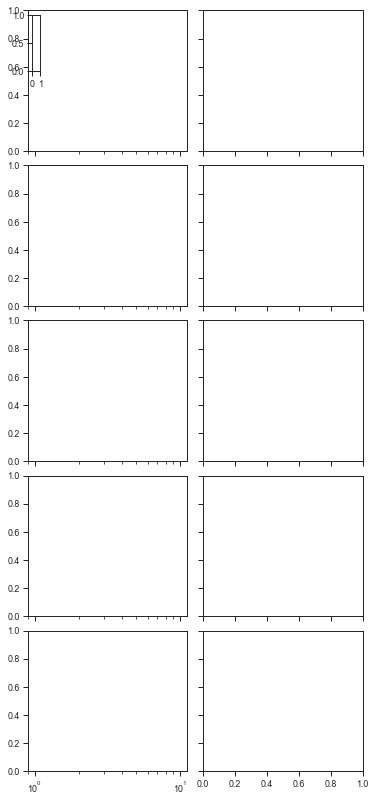

In [37]:
sns.set_context('paper')
def cbar_inset(ax):
    axins = inset_axes(ax,
                        width="5%",  # width = 50% of parent_bbox width
                        height="40%",  # height : 5%
                        loc='upper left')
    return axins
nbins=40
ms = 10
a=0.5
labels=['Initial Biomass','IPTG (mM)',r' $\overline{IC}_{se}$ (m)',r' $\overline{IC}_{ec}$ (m)','Distance from Center (m)']
fig = plt.figure(figsize=(6,14))
my_gridspec = gridspec.GridSpec(len(selected_features), 2, figure=fig,wspace=.1,hspace=.1)
#f, axes = plt.subplots(ncols=2,nrows=len(selected_features),figsize=(4,16))
logs = [(True,False),True,(True,False),(True,False),True]
axes = my_gridspec.subplots(sharex='col', sharey='row')#
lvls = 20
for met,ax,lgs in zip(selected_features,axes[:,0],logs):
   d1 = data.loc[data.type==1]
    
   #cya = colorFader('#01665e','#c7eae5',lvls)
   cya = sns.light_palette('#01665e', as_cmap=True)
   sns.histplot(x='total biomass',y=met,data=d1,ax=ax,log_scale=lgs,cmap=cya,bins=nbins,cbar=True,cbar_ax=cbar_inset(ax))
   #ax.scatter(x=d1['total biomass'],y=d1[met],s=ms,c=cya,alpha=a,ec='k',lw=.5,rasterized=True)
    
   ax.set_ylabel(met)
   #ax.set_xlim(1e3,1e7)
   #
for met,ax,lgs in zip(selected_features,axes[:,1],logs):
   d2 = data.loc[data.type==2]
   #ecw = colorFader('#8c510a','#f6e8c3',len(d2[met]))
   ecw = sns.light_palette('#8c510a',as_cmap=True)
   sns.histplot(x='total biomass',y=met,data=d2,ax=ax,log_scale=lgs,cmap=ecw,bins=nbins,cbar=True,cbar_ax=cbar_inset(ax))
   #ax.scatter(x=d2['total biomass'],y=d2[met],s=ms,c=ecw,alpha=a,ec='k',lw=.5,rasterized=True)
   ax.set_ylabel(met)
   
   #ax.set_xlim(1e1,1e7)
   #sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
for ax in axes.ravel():
   ax.set_xscale('log')
   
for ax in axes[:,1]:
   ax.set_ylabel('')
#axes[-1,0].set_xlabel('Total Biomass (fg)')  
#for i in [0,2,3]:
#   axes[i,0].set_yscale('log')
#   axes[i,1].set_yscale('log')
axes[-1,0].set_xlabel('Total Biomass (fg)')
axes[-1,1].set_xlabel('Total Biomass (fg)')
axes[0,0].set_title(r'$\it{S. elongatus}$')
axes[0,1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
for ax,label in zip(axes[:,0],labels):
   ax.set_ylabel(label)
#fig.tight_layout()


#fig.savefig('../figures/spatial-metrics.pdf',bbox_inches='tight')
#fig.savefig('../figures/spatial-metrics-density.png',bbox_inches='tight',dpi=600)
plt.show()

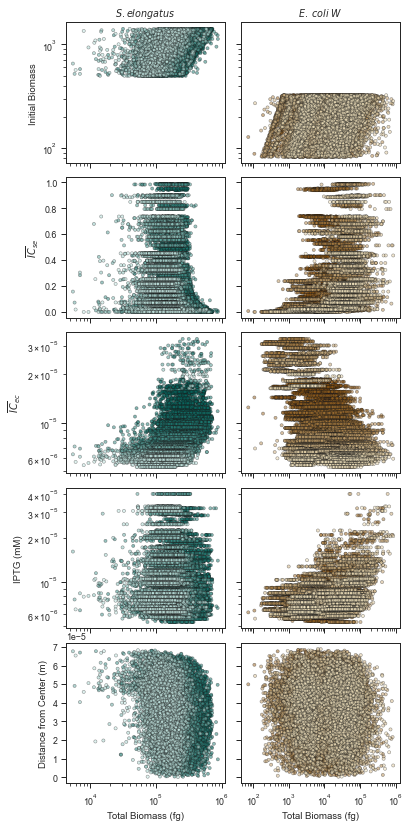

In [ ]:
sns.set_context('paper')
ms = 10
a=0.5
labels=['Initial Biomass',r' $\overline{IC}_{se}$',r' $\overline{IC}_{ec}$','IPTG (mM)','Distance from Center (m)']
fig = plt.figure(figsize=(6,14))
my_gridspec = gridspec.GridSpec(len(selected_features), 2, figure=fig,wspace=.1,hspace=.1)
#f, axes = plt.subplots(ncols=2,nrows=len(selected_features),figsize=(4,16))
axes = my_gridspec.subplots(sharex='col', sharey='row')
for met,ax in zip(selected_features,axes[:,0]):
   d1 = data.loc[data.type==1]
    
   cya = colorFader('#01665e','#c7eae5',len(d1[met]))
    
   ax.scatter(x=d1['total biomass'],y=d1[met],s=ms,c=cya,alpha=a,ec='k',lw=.5,rasterized=True)
    
   ax.set_ylabel(met)
   #ax.set_xlim(1e3,1e7)
   #
for met,ax in zip(selected_features,axes[:,1]):
   d2 = data.loc[data.type==2]
   ecw = colorFader('#8c510a','#f6e8c3',len(d2[met]))
   ax.scatter(x=d2['total biomass'],y=d2[met],s=ms,c=ecw,alpha=a,ec='k',lw=.5,rasterized=True)
   ax.set_ylabel(met)
   
   #ax.set_xlim(1e1,1e7)
   #sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
for ax in axes.ravel():
   ax.set_xscale('log')
   
for ax in axes[:,1]:
   ax.set_ylabel('')
#axes[-1,0].set_xlabel('Total Biomass (fg)')  
for i in [0,2,3]:
   axes[i,0].set_yscale('log')
   axes[i,1].set_yscale('log')
axes[-1,0].set_xlabel('Total Biomass (fg)')
axes[-1,1].set_xlabel('Total Biomass (fg)')
axes[0,0].set_title(r'$\it{S. elongatus}$')
axes[0,1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
for ax,label in zip(axes[:,0],labels):
   ax.set_ylabel(label)
#fig.tight_layout()


#fig.savefig('../figures/spatial-metrics.pdf',bbox_inches='tight',dpi=1200)
#fig.savefig('../figures/spatial-metrics.png',bbox_inches='tight',dpi=1200)
plt.show()


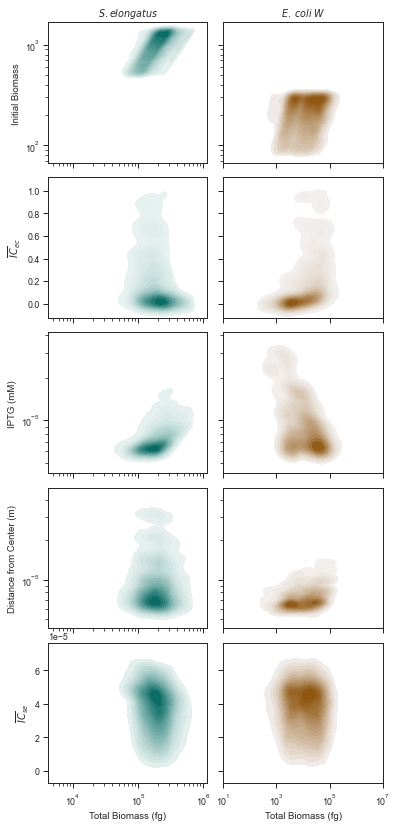

In [ ]:
sns.set_context('paper')
ms = 10
a=0.5
labels=['Initial Biomass',r' $\overline{IC}_{ec}$','IPTG (mM)','Distance from Center (m)',r' $\overline{IC}_{se}$']
fig = plt.figure(figsize=(6,14))
my_gridspec = gridspec.GridSpec(len(selected_features), 2, figure=fig,wspace=.1,hspace=.1)
#f, axes = plt.subplots(ncols=2,nrows=len(selected_features),figsize=(4,16))
logs = [True,(True,False),True,True,(True,False)]
axes = my_gridspec.subplots(sharex='col', sharey='row')
lvls = 20
for met,ax,lg in zip(selected_features,axes[:,0],logs):
   d1 = data.loc[data.type==1]
    
   #cya = colorFader('#01665e','#c7eae5',lvls)
   cya = sns.light_palette('#01665e', as_cmap=True)
   sns.kdeplot(x='total biomass',y=met,data=d1,ax=ax,log_scale=lg,fill=True, levels=lvls,cmap=cya)
   #ax.scatter(x=d1['total biomass'],y=d1[met],s=ms,c=cya,alpha=a,ec='k',lw=.5,rasterized=True)
    
   ax.set_ylabel(met)
   #ax.set_xlim(1e3,1e7)
   #
for met,ax,lg in zip(selected_features,axes[:,1],logs):
   d2 = data.loc[data.type==2]
   #ecw = colorFader('#8c510a','#f6e8c3',len(d2[met]))
   ecw = sns.light_palette('#8c510a',as_cmap=True)
   sns.kdeplot(x='total biomass',y=met,data=d2,ax=ax,log_scale=lg,fill=True, levels=lvls,cmap=ecw)
   #ax.scatter(x=d2['total biomass'],y=d2[met],s=ms,c=ecw,alpha=a,ec='k',lw=.5,rasterized=True)
   ax.set_ylabel(met)
   
   ax.set_xlim(1e1,1e7)
   #sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
for ax in axes.ravel():
   ax.set_xscale('log')
   
for ax in axes[:,1]:
   ax.set_ylabel('')
#axes[-1,0].set_xlabel('Total Biomass (fg)')  
#for i in [0,2,3]:
#   axes[i,0].set_yscale('log')
#   axes[i,1].set_yscale('log')
axes[-1,0].set_xlabel('Total Biomass (fg)')
axes[-1,1].set_xlabel('Total Biomass (fg)')
axes[0,0].set_title(r'$\it{S. elongatus}$')
axes[0,1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
for ax,label in zip(axes[:,0],labels):
   ax.set_ylabel(label)
#fig.tight_layout()


#fig.savefig('../figures/spatial-metrics.pdf',bbox_inches='tight',dpi=1200)
#fig.savefig('../figures/spatial-metrics-density.png',bbox_inches='tight',dpi=600)
plt.show()

In [ ]:
data.columns

Index(['mother_cell', 'type', 'Voronoi Area', 'IPTG', 'Time',
       'Distance from center', 'total biomass', 'Nearest 1', 'Nearest 2',
       'Nearest Neighbor', 'IC1', 'IC2', 'IC', 'Relative Neighbor Dist 1',
       'Relative Neighbor Dist 2', 'Relative Neighbor Dist', 'Z1', 'Z2',
       'Z1_2', 'Z2_1', 'LogNearest 1', 'LogNearest 2', 'LogNearest', 'Inv1',
       'Inv2', 'Log Inv1', 'Log Inv2', 'Colony Area', 'initial biomass'],
      dtype='object')

In [ ]:
features=list(selected_features)
features.append('total biomass')
features.append('type')

In [ ]:
metric_data = data[features]

In [ ]:
metric_data

,type,initial biomass,Time,IC2,Distance from center,total biomass,type
0,2,178.418964,97.222222,0.000010,0.000042,18725.174159,2
1,2,309.662175,97.222222,0.000010,0.000047,13613.387479,2
2,2,164.700681,97.222222,0.000010,0.000046,7314.070579,2
3,2,131.594619,97.222222,0.000010,0.000035,12999.941624,2
4,2,213.345049,97.222222,0.000010,0.000046,21866.197226,2
...,...,...,...,...,...,...,...
90,1,854.539005,97.222222,0.000007,0.000050,360743.295668,1
91,1,1266.849913,97.222222,0.000007,0.000013,535526.268738,1
92,1,590.614837,97.222222,0.000007,0.000038,332272.304106,1
93,1,1414.508417,97.222222,0.000007,0.000048,577973.344035,1


In [39]:
data

,mother_cell,type,Voronoi Area,IPTG,Time,Distance from center,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,...,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,initial biomass
0,33,2,1.978817e-10,0.36692,97.222222,0.000042,18725.174159,1.068169e-05,0.000006,6.013393e-06,...,125.942342,-11.446980,-12.021521,-12.021521,9.361819e+04,166295.456827,22.893960,24.043043,15232.0,178.418964
1,32,2,1.943819e-10,0.36692,97.222222,0.000047,13613.387479,2.400483e-05,0.000004,4.053653e-06,...,84.898239,-10.637255,-12.415892,-12.415892,4.165827e+04,246691.090842,21.274511,24.831784,11924.0,309.662175
2,20,2,4.030559e-10,0.36692,97.222222,0.000046,7314.070579,2.989025e-05,0.000005,4.605432e-06,...,96.454498,-10.417978,-12.288274,-12.288274,3.345573e+04,217134.916354,20.835957,24.576548,6598.0,164.700681
3,26,2,7.323750e-10,0.36692,97.222222,0.000035,12999.941624,1.687371e-05,0.000009,9.452322e-06,...,197.966032,-10.989754,-11.569250,-11.569250,5.926379e+04,105794.105481,21.979507,23.138500,11925.0,131.594619
4,14,2,9.573191e-10,0.36692,97.222222,0.000046,21866.197226,1.254053e-05,0.000006,6.013393e-06,...,125.942342,-11.286545,-12.021521,-12.021521,7.974144e+04,166295.456827,22.573089,24.043043,15693.0,213.345049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3,1,2.044298e-09,0.02123,97.222222,0.000050,360743.295668,3.564515e-05,0.000006,5.577490e-06,...,174.689003,-10.241898,-12.096772,-12.096772,2.805431e+04,179292.103583,20.483795,24.193543,84957.0,854.539005
91,4,1,6.977255e-09,0.02123,97.222222,0.000013,535526.268738,1.774832e-05,0.000003,3.361547e-06,...,105.284866,-10.939220,-12.603109,-12.603109,5.634336e+04,297482.058654,21.878439,25.206218,118240.0,1266.849913
92,9,1,3.902051e-09,0.02123,97.222222,0.000038,332272.304106,8.139410e-07,0.000004,8.139410e-07,...,117.909816,-14.021378,-12.489859,-14.021378,1.228590e+06,265629.782806,28.042756,24.979718,72333.0,590.614837
93,5,1,0.000000e+00,0.02123,97.222222,0.000048,577973.344035,1.815485e-05,0.000005,5.195306e-06,...,162.718834,-10.916573,-12.167755,-12.167755,5.508171e+04,192481.459635,21.833146,24.335510,119251.0,1414.508417


KeyboardInterrupt: 

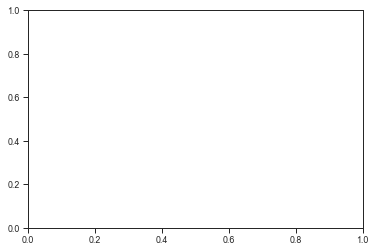

In [40]:
sns.histplot(x='total biomass',y='initial biomass',data=data)